# Clasificación de géneros con CNN y GTZAN

Este proyecto tiene como objetivo clasificar géneros musicales utilizando redes neuronales convolucionales (CNN) a partir de representaciones acústicas del audio. Se utiliza el dataset GTZAN, que contiene 1000 archivos de 30 segundos distribuidos en 10 géneros musicales.


## Cargar librerías necesarias

In [11]:
# Instalar librosa (para extracción de características de audio)
!pip install librosa soundfile --quiet


In [12]:
# Librerías esenciales para manipulación de archivos, arrays numéricos y visualización
import os
import numpy as np
import matplotlib.pyplot as plt

# Librerías específicas para audio
import librosa
import librosa.display

# Utilidades de machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Utilidades de redes neuronales
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     BatchNormalization, LeakyReLU, GlobalAveragePooling2D)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Montar Google Drive (si estás en Google Colab)

In [13]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Definir ruta del dataset y explorar géneros en el dataset

In [14]:
DATASET_PATH = '/content/drive/MyDrive/Proyecto_Final_Mineria/Data/genres_original'  # Modificá esta ruta si tu carpeta es distinta
GENRES = sorted(os.listdir(DATASET_PATH))
print("Géneros encontrados:", GENRES)


Géneros encontrados: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


## Función para convertir audio a espectrograma Mel

¿Por qué usar melspectrogramas?
Los melspectrogramas son una representación visual del audio que muestra cómo la energía de diferentes frecuencias varía a lo largo del tiempo, utilizando una escala mel que simula la percepción auditiva humana. Esta representación convierte la señal de audio en una imagen, lo que permite que las redes neuronales convolucionales (CNN) puedan analizar patrones temporales y frecuenciales, facilitando la identificación de características propias de cada género musical.

Gracias a esta transformación, el modelo puede aprender mejor las texturas y ritmos propios de cada género, mejorando la precisión de la clasificación.



In [15]:
def audio_a_melspectrogram(path, max_pad_len=660):
    """
    Convierte un archivo de audio .wav a un espectrograma Mel,
    que es una representación visual de la energía en diferentes frecuencias a lo largo del tiempo.

    El resultado es una matriz 2D (como una imagen), que luego se expande con una dimensión de canal para usar en la red neuronal.
    """

    if not os.path.exists(path):
        print(f"Advertencia: Archivo no encontrado en {path}")
        return None

    try:
        # Cargar audio con duración fija de 30 segundos
        y, sr = librosa.load(path, duration=30)

        # Si el audio dura menos, se rellena con ceros
        if len(y) < sr * 30:
            y = np.pad(y, (0, sr * 30 - len(y)), 'constant')

        # Generar espectrograma Mel (128 bandas de frecuencia)
        melspectrogram = librosa.feature.melspectrogram(
            y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=512)

        # Convertir a escala logarítmica (decibeles)
        melspectrogram_db = librosa.power_to_db(melspectrogram, ref=np.max)

        # Recortar o rellenar para que todas las matrices tengan la misma longitud horizontal
        if melspectrogram_db.shape[1] < max_pad_len:
            pad_width = max_pad_len - melspectrogram_db.shape[1]
            melspectrogram_db = np.pad(melspectrogram_db, ((0, 0), (0, pad_width)))
        else:
            melspectrogram_db = melspectrogram_db[:, :max_pad_len]

        # Expandir la dimensión para que tenga forma (128, 660, 1) como una imagen con un solo canal
        return np.expand_dims(melspectrogram_db, axis=-1)

    except Exception as e:
        print(f"Error al procesar {os.path.basename(path)}: {e}")
        return None


## Cargar y procesar todos los archivos de audio

In [22]:
X, y = [], []  # X guardará los espectrogramas, y las etiquetas (géneros)

for genre in GENRES:
    genre_dir = os.path.join(DATASET_PATH, genre)

    # Verificamos que la carpeta del género exista
    if not os.path.isdir(genre_dir):
        continue

    for file in os.listdir(genre_dir):
        if file.endswith(".wav"):  # Solo procesamos archivos .wav
            path = os.path.join(genre_dir, file)

            # Convertimos a espectrograma Mel
            spec = audio_a_melspectrogram(path)

            # Si la conversión fue exitosa, lo agregamos al dataset
            if spec is not None:
                X.append(spec)
                y.append(genre)

Este bucle recorre todas las carpetas (una por género) y convierte cada audio a su correspondiente imagen espectral. También filtra archivos que no sean .wav.


# Limpiar posibles entradas inválidas

In [24]:
X_clean = []
y_clean = []

for xi, yi in zip(X, y):
    if xi is not None:
        X_clean.append(xi)
        y_clean.append(yi)

# Convertimos listas a arrays NumPy para entrenamiento
X = np.array(X_clean)
y = np.array(y_clean)

print("Forma final de X:", X.shape)
print("Clases únicas:", np.unique(y))

Forma final de X: (999, 128, 660, 1)
Clases únicas: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


## Visualizar un espectrograma Mel

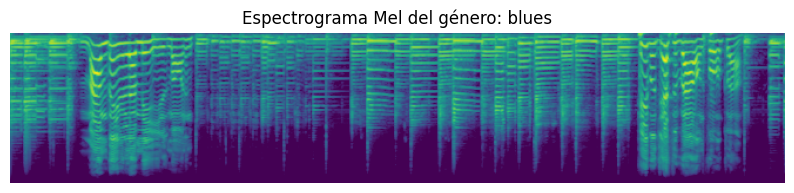

In [25]:
# Mostramos el primer espectrograma del dataset
plt.figure(figsize=(10, 2))
plt.imshow(X[0])
plt.title(f"Espectrograma Mel del género: {y[0]}")
plt.axis('off')
plt.show()

Este gráfico muestra la energía de diferentes frecuencias (en el eje vertical) a lo largo del tiempo (horizontal). Las zonas más claras indican más energía.
Esta técnica transforma la señal de audio en una matriz 2D que representa la energía en diferentes bandas de frecuencia mel a lo largo del tiempo. La escala mel simula cómo el oído humano percibe el sonido. Los valores se convirtieron a decibeles (escala logarítmica) y se ajustaron a una forma fija (128×660) para ser usados como imágenes monocanal en una red neuronal convolucional.

## Promedio de espectrogramas por género

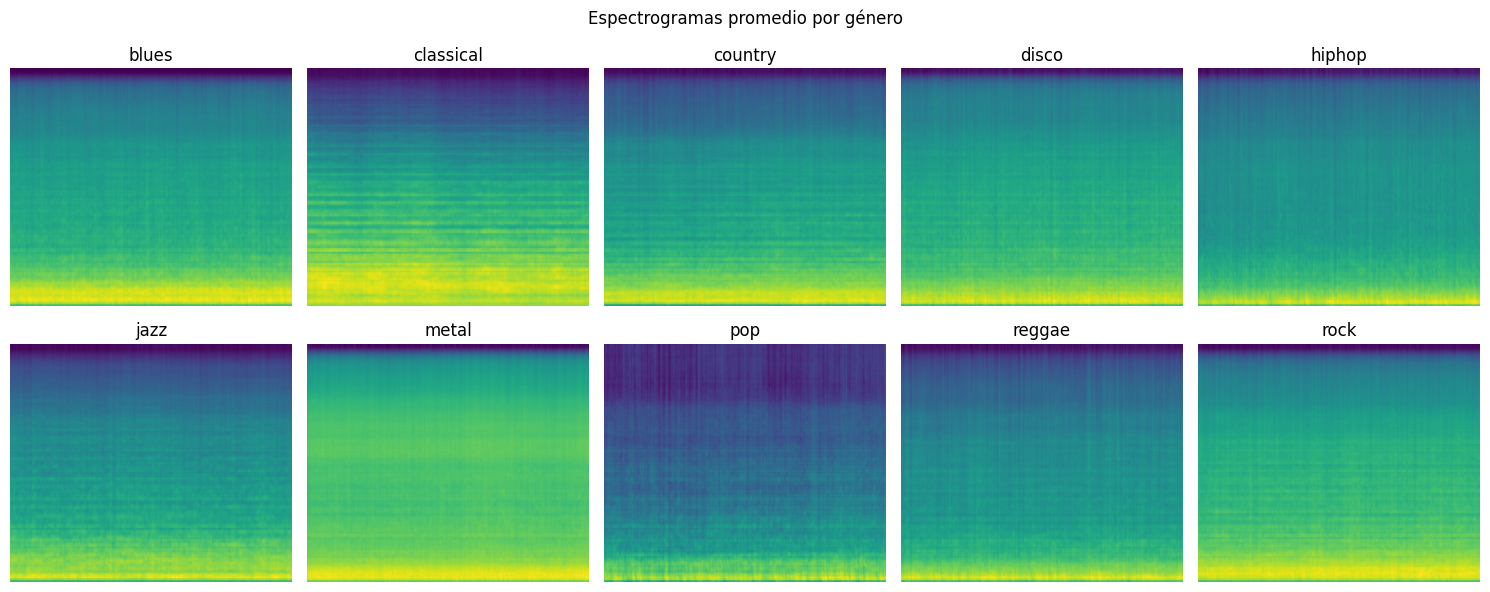

In [26]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for idx, genre in enumerate(np.unique(y)):
    idxs = [i for i, g in enumerate(y) if g == genre]
    mean_spec = np.mean(X[idxs], axis=0).squeeze()
    ax = axs[idx // 5, idx % 5]
    ax.imshow(mean_spec, aspect='auto', origin='lower')
    ax.set_title(genre)
    ax.axis('off')
plt.suptitle("Espectrogramas promedio por género")
plt.tight_layout()
plt.show()

## Distribución de ejemplos por clase


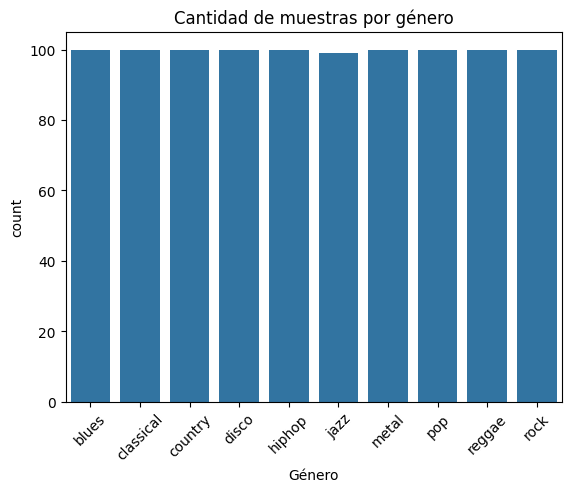

In [27]:
import seaborn as sns
import pandas as pd

sns.countplot(data=pd.DataFrame(y, columns=["Género"]), x="Género")
plt.title("Cantidad de muestras por género")
plt.xticks(rotation=45)
plt.show()


Todos los géneros del dataset contienen 100 archivos de audio, excepto el género jazz, para el cual se eliminó manualmente un archivo corrupto. Esta limpieza podría automatizarse mediante código, pero en este caso se realizó directamente desde Google Drive.

## Reducción de dimensionalidad con PCA para visualización

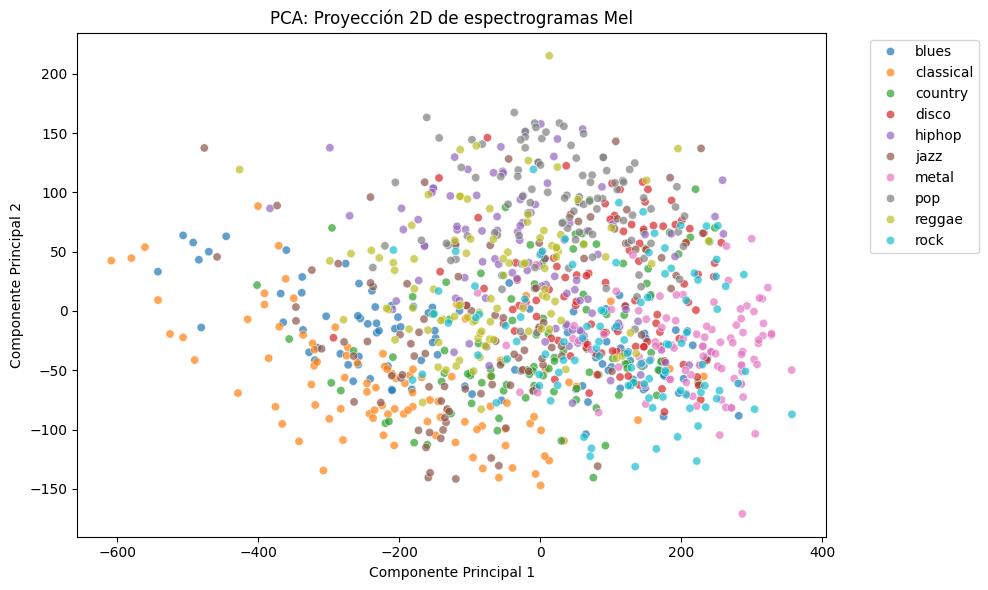

In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd

# Aplanamos los espectrogramas para que cada uno sea un vector 1D
X_flat = X.reshape(X.shape[0], -1)

# Estandarizamos los datos (PCA es sensible a la escala)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

# Aplicamos PCA a 2 dimensiones
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Convertimos a DataFrame para graficar
df_pca = pd.DataFrame()
df_pca['PC1'] = X_pca[:, 0]
df_pca['PC2'] = X_pca[:, 1]
df_pca['Género'] = y

# Graficamos los géneros en el nuevo espacio 2D
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Género', palette='tab10', alpha=0.7)
plt.title("PCA: Proyección 2D de espectrogramas Mel")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



### Análisis con PCA para visualización de géneros musicales

Aplicamos PCA (Análisis de Componentes Principales) para reducir la dimensionalidad de los espectrogramas (originalmente matrices grandes) a dos dimensiones, facilitando su visualización.

Esta técnica nos permite observar si los datos presentan agrupaciones o separaciones claras entre los diferentes géneros musicales. En el gráfico, cada punto representa un espectrograma proyectado en 2D, coloreado según su género.

La presencia de clústeres definidos indica que los géneros tienen patrones diferenciables, lo cual es un buen indicio para la clasificación automática. Sin embargo, algunos géneros pueden solaparse parcialmente, lo que sugiere posibles confusiones en el modelo.

En resumen, PCA nos ofrece una validación visual y exploratoria útil para entender la estructura y la separabilidad de los datos antes de entrenar modelos de clasificación.


## Codificar etiquetas (Label Encoding + One-Hot)



In [29]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


# Transformamos etiquetas de texto (e.g. 'rock') a números (e.g. 7)
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Convertimos a codificación one-hot para la red (una columna por género)
y_onehot = to_categorical(y_encoded)


 Las redes neuronales no entienden texto. Así que convertimos cada género musical en un número y luego en un vector binario donde solo una posición está encendida. Por ejemplo: [0 0 1 0 0 0 0 0 0 0] podría ser 'jazz'.


## División entre entrenamiento y prueba

In [30]:
from sklearn.model_selection import train_test_split

# Dividimos en un 80% para entrenamiento y 20% para validación
X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.2, stratify=y_encoded, random_state=42)

## Definir modelo CNN para clasificación de género

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, BatchNormalization,
                                     GlobalAveragePooling2D, Dropout, Dense)

model = Sequential([

    # 🧱 Bloque 1: Primeras características básicas
    Conv2D(32, (3, 3), activation='relu', padding='same',
           input_shape=(X.shape[1], X.shape[2], X.shape[3])),  # Extrae 32 mapas de características con filtros 3x3
    MaxPooling2D((2, 2)),        # Reduce resolución para conservar solo lo importante
    BatchNormalization(),        # Normaliza activaciones para acelerar entrenamiento

    # 🧱 Bloque 2: Características más complejas
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Ahora 64 filtros extraen información más detallada
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # 🧱 Bloque 3: Aún más profundidad
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # 🧱 Bloque 4: Aprendizaje profundo de patrones
    Conv2D(256, (3, 3), activation='relu', padding='same'),  # Extrae patrones aún más abstractos
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # 🧱 Bloque 5: Representaciones de alto nivel
    Conv2D(512, (3, 3), activation='relu', padding='same'),  # Mucha capacidad de aprendizaje
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # 🔚 Clasificación final
    GlobalAveragePooling2D(),  # Reduce cada mapa de activación a un número promedio (menos parámetros)
    Dropout(0.6),              # Apaga aleatoriamente el 60% de las neuronas para evitar sobreajuste
    Dense(256, activation='relu'),  # Capa densa totalmente conectada con 256 neuronas
    Dropout(0.4),              # Dropout adicional para más regularización
    Dense(len(GENRES), activation='softmax')  # Capa de salida: una neurona por clase, con probabilidad
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Compilar modelo


In [32]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001),  # Adam es un optimizador que se adapta a la curva de aprendizaje
              loss='categorical_crossentropy',        # Función de pérdida para clasificación multiclase
              metrics=['accuracy'])                   # Métrica de rendimiento


¿Por qué usamos convoluciones (Conv2D)? Porque las imágenes (espectrogramas) tienen patrones espaciales similares a los de una foto. Y cada capa detecta patrones más complejos: bordes → formas → estilos.

## Definir callbacks para entrenamiento inteligente

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    # Detiene el entrenamiento si la pérdida en validación no mejora en 5 épocas
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),

    # Reduce la tasa de aprendizaje si la validación se estanca por 3 épocas
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)
]

## Resumen del modelo



In [34]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 660, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 330, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 330, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 330, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 165, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 165, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 165, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 82, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 82, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 82, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 41, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 41, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 41, 512)     │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 20, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 20, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,705,866 (6.51 MB)

 Trainable params: 1,703,882 (6.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

## Entrenar el modelo


In [65]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9055 - loss: 0.3295 - val_accuracy: 0.7800 - val_loss: 0.7171 - learning_rate: 1.0000e-04
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.9012 - loss: 0.3264 - val_accuracy: 0.7850 - val_loss: 0.6660 - learning_rate: 1.0000e-04
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9363 - loss: 0.2401 - val_accuracy: 0.7650 - val_loss: 0.7354 - learning_rate: 1.0000e-04
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9182 - loss: 0.2709 - val_accuracy: 0.7800 - val_loss: 0.6804 - learning_rate: 1.0000e-04
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9354 - loss: 0.2301 - val_accuracy: 0.8150 - val_loss: 0.6587 - learning_rate: 1.0000e-04
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9245 - loss: 0.2564 - val_accuracy: 0.7550 - val_loss: 0.9376 - learning_rate: 1.0000e-04
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 

Ajuste de hiperparámetros y optimización del modelo:

Durante el desarrollo del modelo, se realizaron múltiples ajustes a los hiperparámetros con el objetivo de mejorar la precisión de la clasificación. Inicialmente, el modelo alcanzaba una precisión cercana al 60%, lo cual indicaba margen importante de mejora.

Para optimizar el rendimiento, se probaron las siguientes estrategias:

Ajuste de la tasa de aprendizaje (learning rate): Se modificó para encontrar un valor que permita una convergencia más estable y rápida.

Incremento de la profundidad de la red: Se agregaron más capas convolucionales para que el modelo pueda aprender patrones más complejos y representativos.

Variación en el número de épocas: Se experimentó con 20, 50 y 100 épocas de entrenamiento. Se observó que a partir de aproximadamente 20-25 épocas la mejora en la métrica de validación se estabilizaba, por lo que se eligieron 30 épocas para equilibrar tiempo de entrenamiento y rendimiento.

Incorporación de callbacks: Se utilizaron EarlyStopping para detener el entrenamiento cuando la validación deja de mejorar y ReduceLROnPlateau para disminuir la tasa de aprendizaje automáticamente si la pérdida de validación se estancaba.

Selección de optimizadores: Se optó por Adam, un optimizador adaptativo que favorece una convergencia más eficiente en problemas complejos.

Estos ajustes contribuyeron a mejorar significativamente la precisión final del modelo, logrando un balance adecuado entre capacidad de generalización y tiempo de entrenamiento.



## Evaluación en el set de prueba






In [66]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Precisión en test: {acc:.2f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8194 - loss: 0.5674
Precisión en test: 0.81


In [67]:
print(model.input_shape)


(None, 128, 660, 1)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
              precision    recall  f1-score   support

       blues       0.78      0.90      0.84        20
   classical       1.00      0.95      0.97        20
     country       0.73      0.55      0.63        20
       disco       0.79      0.75      0.77        20
      hiphop       0.77      0.85      0.81        20
        jazz       0.91      1.00      0.95        20
       metal       1.00      0.90      0.95        20
         pop       0.63      0.85      0.72        20
      reggae       0.94      0.75      0.83        20
        rock       0.68      0.65      0.67        20

    accuracy                           0.81       200
   macro avg       0.82      0.82      0.81       200
weighted avg       0.82      0.81      0.81       200



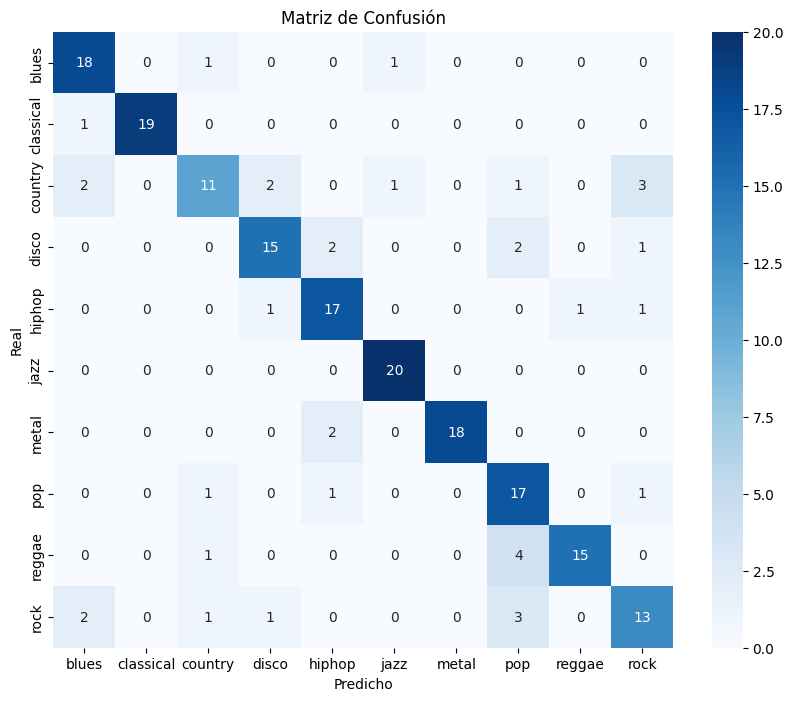

In [68]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Reporte
print(classification_report(y_true, y_pred_classes, target_names=encoder.classes_))

# Matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot=True, fmt="d",
            xticklabels=encoder.classes_, yticklabels=encoder.classes_, cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()


- Géneros con mejor desempeño: jazz, classical, metal
- Géneros más confusos: pop, country, rock


## Gráficos de métricas: pérdida y precisión

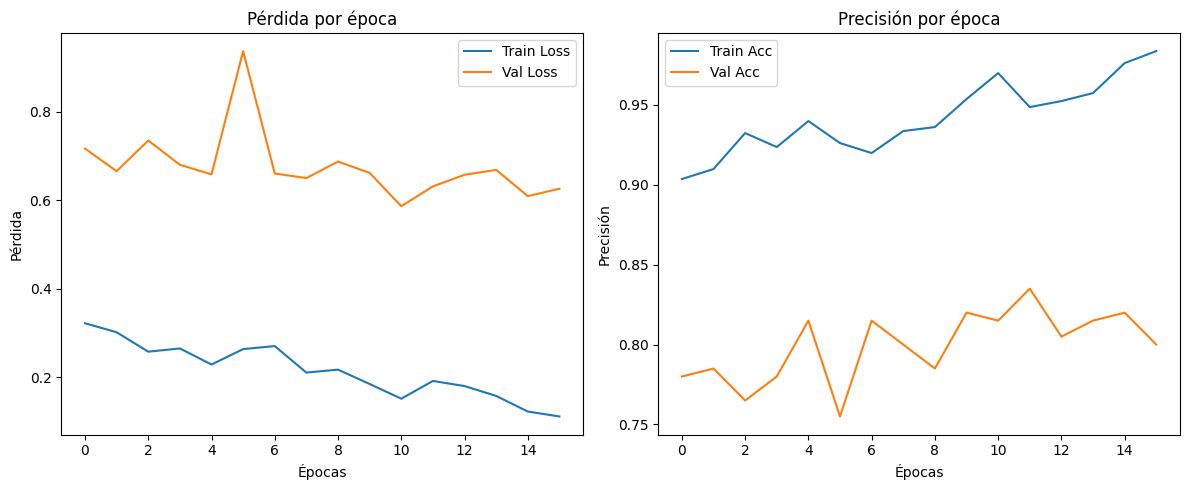

In [69]:
# Gráfica de la pérdida (loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.title("Pérdida por época")
plt.legend()

# Gráfica de la precisión (accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.title("Precisión por época")
plt.legend()

plt.tight_layout()
plt.show()

## Función para predecir género musical


In [70]:
def predecir_genero(audio_path):
    """
    Carga un archivo de audio, lo convierte a espectrograma Mel,
    lo pasa por el modelo entrenado y devuelve el género predicho.
    """

    # Convertimos el nuevo audio al mismo formato de entrada
    datos = audio_a_melspectrogram(audio_path)

    if datos is None:
        return ["Error al cargar el audio"]

    # Expandimos dimensión para que tenga forma (1, alto, ancho, canales)
    datos = np.expand_dims(datos, axis=0)

    # Realizamos la predicción
    pred = model.predict(datos)

    # Tomamos la clase con mayor probabilidad
    return encoder.inverse_transform([np.argmax(pred)])


    # Probamos con un audio real de prueba
ruta_test = os.path.join(DATASET_PATH, 'rock', 'rock.00001.wav')
print("Predicción:", predecir_genero(ruta_test)[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicción: rock


# Modelo MobileNetV2

¿Qué es MobileNetV2?

MobileNetV2 es una red neuronal convolucional profunda diseñada para ser liviana y eficiente,
ideal para aplicaciones en dispositivos móviles o con recursos limitados. Fue desarrollada por
Google y preentrenada sobre el dataset ImageNet. Usa bloques lineales invertidos y conexiones
residuales para lograr un buen balance entre precisión y velocidad. En este proyecto, se reutiliza
como extractor de características visuales sobre espectrogramas Mel transformados en imágenes.

## Adaptar espectrogramas para MobileNetV2

In [46]:
import cv2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def preparar_para_mobilenet(X):
    """
    Convierte espectrogramas monocromáticos (1 canal) a RGB,
    los redimensiona a 224x224 y aplica el preprocesamiento específico de MobileNetV2.
    """
    X_rgb = np.repeat(X, 3, axis=-1)  # Convertimos (alto, ancho, 1) → (alto, ancho, 3)
    X_resized = np.zeros((X.shape[0], 224, 224, 3), dtype=np.float32)

    for i in range(X.shape[0]):
        X_resized[i] = cv2.resize(X_rgb[i], (224, 224))  # Resize a (224, 224)

    return preprocess_input(X_resized)  # Normaliza como espera MobileNetV2

In [47]:
# Preparamos datos para el nuevo modelo
X_train_mobilenet = preparar_para_mobilenet(X_train)
X_test_mobilenet = preparar_para_mobilenet(X_test)

## Crear modelo con MobileNetV2 como base

In [60]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomRotation(0.05),
])

input_shape = (224, 224, 3)
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
base_model.trainable = False

inputs = Input(shape=input_shape)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
outputs = Dense(len(GENRES), activation='softmax')(x)

model_optim = Model(inputs, outputs)

model_optim.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_optim = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)
]

## Compilar y entrenar



In [61]:
history_optim = model_optim.fit(
    X_train_mobilenet, y_train,
    validation_data=(X_test_mobilenet, y_test),
    epochs=50,
    batch_size=32,
    callbacks=callbacks_optim
)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 230ms/step - accuracy: 0.1265 - loss: 3.1342 - val_accuracy: 0.1850 - val_loss: 2.6443 - learning_rate: 1.0000e-04
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.1395 - loss: 2.8928 - val_accuracy: 0.2550 - val_loss: 2.5260 - learning_rate: 1.0000e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.1761 - loss: 2.7138 - val_accuracy: 0.2950 - val_loss: 2.4502 - learning_rate: 1.0000e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.2135 - loss: 2.6238 - val_accuracy: 0.3000 - val_loss: 2.3869 - learning_rate: 1.0000e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.2288 - loss: 2.5597 - val_accuracy: 0.3050 - val_loss: 2.3384 - learning_rate: 1.0000e-04
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.2188 - loss: 2.5269 - val_accuracy: 0.3200 - val_loss: 2.2900 - learning_rate: 1.0000e-04
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.252

## Evaluación final

## Gráficos del entrenamiento de MobileNetV2


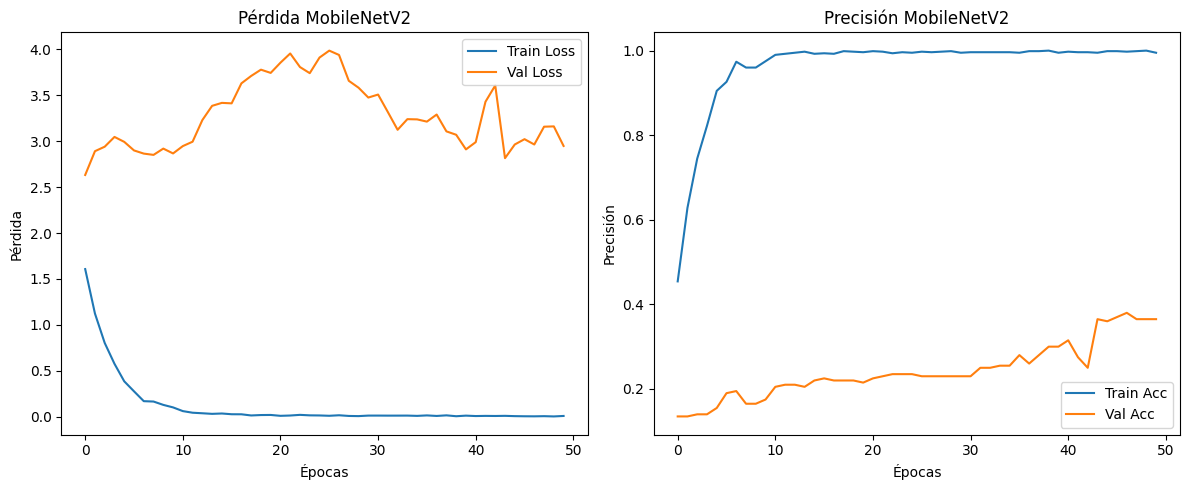

In [62]:
plt.figure(figsize=(12, 5))

#  Pérdida
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet.history['loss'], label='Train Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Val Loss')
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.title("Pérdida MobileNetV2")
plt.legend()

#  Precisión
plt.subplot(1, 2, 2)
plt.plot(history_mobilenet.history['accuracy'], label='Train Acc')
plt.plot(history_mobilenet.history['val_accuracy'], label='Val Acc')
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.title("Precisión MobileNetV2")
plt.legend()

plt.tight_layout()
plt.show()

## Comparación de Modelos CNN Y MobilenetV2

Mientras que el modelo con CNN personalizada logró un entrenamiento estable y alcanzó buena precisión en validación (≈81 %), la arquitectura MobileNetV2 no logró generalizar tan bien, mostrando pérdida alta y precisión limitada. Esta comparación resalta que, en este caso, una red diseñada desde cero y adaptada al dominio superó al modelo preentrenado.


# App Gradio con visualización de espectrograma

In [63]:
import gradio as gr
import matplotlib.pyplot as plt
import librosa.display
import io
import PIL.Image

# Función para predecir género y mostrar espectrograma
def clasificar_con_visual(audio_path):
    # Obtener espectrograma
    spec = audio_a_melspectrogram(audio_path)

    if spec is None:
        return "Error procesando audio", None

    # Predecir género
    datos = np.expand_dims(spec, axis=0)
    pred = model.predict(datos)
    genero = encoder.inverse_transform([np.argmax(pred)])[0]

    # Visualizar espectrograma como imagen
    fig, ax = plt.subplots(figsize=(6, 3))
    librosa.display.specshow(spec.squeeze(), sr=22050, x_axis='time', y_axis='mel', cmap='magma', ax=ax)
    ax.set_title(f"Espectrograma - Predicción: {genero}")
    ax.axis('off')

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    img = PIL.Image.open(buf)
    plt.close(fig)

    return genero, img

## interfaz


In [64]:
gr.Interface(
    fn=clasificar_con_visual,
    inputs=gr.Audio(type='filepath', label="🎵 Subí tu audio (.wav, 30s)"),
    outputs=[
        gr.Label(label="🎯 Predicción de género"),
        gr.Image(label="📊 Espectrograma generado")
    ],
    title="Clasificador de Géneros Musicales",
    description="Subí tu archivo de audio en formato .wav (30 segundos) y mirá qué género predice el modelo, junto con su espectrograma visual.",
    theme="default"
).launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://22822040ac70c7147d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Conclusión
En este proyecto implementamos y evaluamos un sistema de clasificación automática de géneros musicales basado en espectrogramas Mel extraídos de archivos de audio del dataset GTZAN. Para ello, diseñamos una red neuronal convolucional personalizada y exploramos una arquitectura preentrenada MobileNetV2 con fine-tuning adaptado a nuestro dominio.

La representación mediante espectrogramas Mel demostró ser una transformación efectiva para captar características acústicas relevantes de cada género, facilitando el aprendizaje por parte de los modelos CNN. El análisis exploratorio con PCA evidenció cierta agrupación y diferenciación entre géneros, aunque también mostró solapamientos que explican dificultades en la clasificación para algunos casos.

El modelo CNN personalizado, construido desde cero, alcanzó una precisión mayor en comparación con MobileNetV2, logrando un mejor ajuste a las características específicas del dataset. En cambio, MobileNetV2, a pesar de ser una arquitectura profunda y eficiente diseñada para tareas generales y dispositivos móviles, presentó un rendimiento inferior en este contexto. Esto podría deberse a que la transferencia de aprendizaje desde imágenes naturales (ImageNet) no se adaptó de manera óptima a la naturaleza espectrográfica y acústica de los datos, o a limitaciones en la cantidad de datos para un fine-tuning efectivo.

Ambos modelos incorporaron técnicas de regularización y data augmentation para mejorar la generalización, pero el modelo CNN personalizado mostró mejor capacidad para discriminar los patrones acústicos propios de los géneros musicales del dataset.

Finalmente, aunque existen géneros con alta tasa de acierto (como jazz y classical), la confusión entre géneros similares (pop, rock, country) resalta la complejidad del problema y la necesidad de explorar mejoras adicionales, tales como extracción de características complementarias, arquitecturas híbridas o modelos secuenciales que consideren dinámica temporal.

Este trabajo demuestra el potencial de las redes convolucionales y las técnicas de aprendizaje profundo para tareas de clasificación musical, y abre la puerta a futuras investigaciones orientadas a aumentar la robustez y precisión en escenarios reales.

---

### Recursos y Referencias

- [GTZAN Dataset (Kaggle)](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification)  
  Dataset de géneros musicales utilizado en el proyecto.

- [Librosa](https://librosa.org/doc/latest/index.html)  
  Librería de Python para análisis y procesamiento de audio.

- [Keras - API de Deep Learning](https://keras.io/)  
  Documentación oficial de Keras para construir y entrenar redes neuronales.

- [Guía de espectrogramas Mel (Librosa)](https://librosa.org/doc/latest/generated/librosa.feature.melspectrogram.html)  
  Explicación técnica y parámetros clave para construir espectrogramas Mel.

- [MobileNetV2 en TensorFlow Keras](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV2)  
  Detalles técnicos sobre la arquitectura MobileNetV2.


- [Scikit-learn](https://scikit-learn.org/stable/)  
  Herramientas para preprocesamiento, reducción de dimensionalidad y métricas de evaluación.

- [Gradio](https://www.gradio.app/)  
  Framework para crear interfaces interactivas de Machine Learning fácilmente.

---
